Dylan Hastings

In [157]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import math

In [158]:
df = pd.read_csv('bank_data.csv')

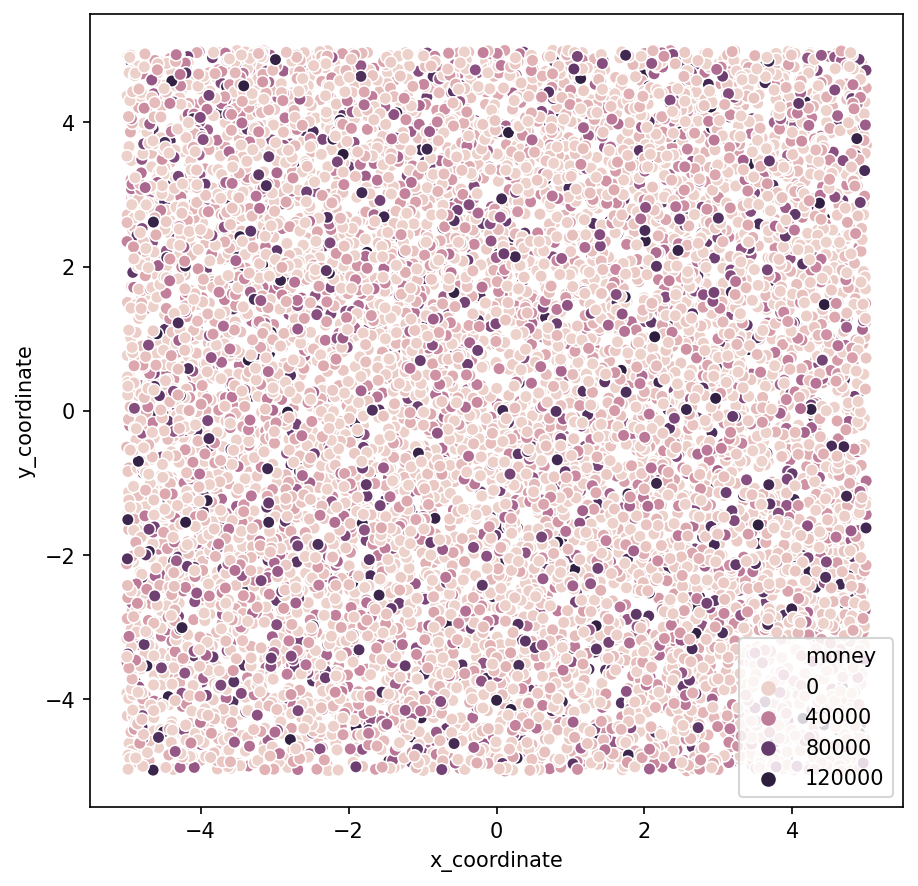

In [159]:
plt.figure(dpi=150, figsize=(7,7))
sb.scatterplot(x = 'x_coordinate', y = 'y_coordinate', data = df, hue = 'money')

In [160]:
df_opt = df
df_opt['money/time'] = df_opt['money'] / df_opt['time (hr)']
df_opt = df_opt.sort_values('money/time', ascending = False)
df_opt = df_opt[:303] #determined by trial and error
df_opt

,id,x_coordinate,y_coordinate,money,time (hr),money/time
3613,3613,-1.950527,-1.495858,54400,0.000186,2.929603e+08
9546,9546,-1.810721,-0.795421,75100,0.000788,9.530556e+07
3803,3803,3.867586,0.918332,18500,0.000358,5.169381e+07
6528,6528,-0.282937,3.224334,33900,0.000769,4.407762e+07
9583,9583,3.393835,-2.790830,24000,0.001131,2.121396e+07
...,...,...,...,...,...,...
3917,3917,-4.395352,3.873021,39200,0.102207,3.835350e+05
6653,6653,-2.977020,2.113585,94200,0.245629,3.835046e+05
4629,4629,3.629193,-3.038079,28800,0.075099,3.834924e+05
6979,6979,2.093818,-2.186226,3800,0.009950,3.819287e+05


In [161]:
def calculate_travel_time(coord1, coord2):
    '''
    This function returns the time to get from
    coordinates (coord1) to (coord2)
    '''
    speed = 30. #km/h
    
    distance = math.sqrt((coord2[0] - coord1[0])**2 + (coord2[1] - coord1[1])**2)
    
    return distance / speed

In [162]:
def find_closest_banks(df, coord, bank_list, distance_threshold, list_length):
    '''
    This function returns the IDs of the closest banks
    to coordinates coord
    '''
    ID_COL = 0 #ID column
    X_COL = 1 #x-coordinate column
    Y_COL = 2 #y-coordinate column
    minimum_distance = float(math.inf)
    closest_ID = 0
    closest_banks = []

    while len(closest_banks) < list_length:
        for x, y, i in zip(df['x_coordinate'], df['y_coordinate'], df['id']):
            delta_x = coord[0] - x
            delta_y = coord[1] - y
            distance = math.sqrt(delta_x**2 + delta_y**2)
        
            if distance < distance_threshold and i not in bank_list and i not in closest_banks:
                closest_ID = i
                minimum_distance = distance
                closest_banks.append(closest_ID)
        if len(closest_banks) < list_length:
            distance_threshold += 0.1

    return closest_banks

In [163]:
def optimum_bank(df, bank_list, coord):
    '''
    This function attempts to find the best bank to rob
    from a list of banks given coordinates coord.
    '''
    best_score = 0
    temp_best = 0
    best_bank = 0
    
    for x, y, i, m, t in zip(df['x_coordinate'], df['y_coordinate'], df['id'],  df['money'],  df['time (hr)']):
        if i in bank_list:
            #best score regardless of distance
            best_score_d = m / t
            
            temp_best = best_score_d / (math.hypot(coord[0] - x, coord[1] - y))
            
            if temp_best > best_score:
                best_score = temp_best
                best_bank = i
    
    return best_bank

In [164]:
def rob_last_bank(df, coord, bank_list, remaining_time):
    '''
    This function returns a list of banks that can be robbed
    before getting back on the helipad
    '''
    available_banks = []
    
    for x, y, i, t in zip(df['x_coordinate'], df['y_coordinate'], df['id'],  df['time (hr)']):
        
        time_to_rob = t
        travel_to_bank = calculate_travel_time(coord, (x,y))
        travel_to_helipad = calculate_travel_time((x,y), (0,0))
        total_time = time_to_rob + travel_to_bank + travel_to_helipad
        
        if total_time < remaining_time and i not in bank_list:
            available_banks.append(i)
    
    return available_banks

In [173]:
def robber_algorithm(df):
    '''
    This algorithm attempts to maximize the amount
    that can be robbed in 24 hours.
    '''
    remaining_time = 24. #hours
    X_COL = 1 #x-coordinate column
    Y_COL = 2 #y-coordinate column
    CASH_COL = 3 #money column
    TIME_COL = 4 #time column
    robbed_banks = []
    best_bank = 0
    start_point = (-2.0,-1.5) #set to location near most optimum bank
    
    while (remaining_time):
        
        #Threshold and list length values determined through trial and error
        closest_banks = find_closest_banks(df_opt, start_point, robbed_banks, 0.6, 2)
        best_bank = optimum_bank(df_opt, closest_banks, start_point)
        
        #Subtract time to rob bank from remaining time
        time_to_rob = df_opt[df_opt['id'] == best_bank].iloc[0][TIME_COL]
        remaining_time -= time_to_rob
        
        #Sutract travel time from remaining time
        travel_time = calculate_travel_time(start_point, (df_opt[df_opt['id'] == best_bank].iloc[0][X_COL],
                          df_opt[df_opt['id'] == best_bank].iloc[0][Y_COL]))
        
        remaining_time -= travel_time
        
        start_point = (df_opt[df_opt['id'] == best_bank].iloc[0][X_COL],
                          df_opt[df_opt['id'] == best_bank].iloc[0][Y_COL])
        
        #append closest bank only if there is time remaining to return to helipad
        if calculate_travel_time(start_point, (0,0)) < remaining_time:
        
            robbed_banks.append(best_bank)
            
        else:
            remaining_time += time_to_rob + travel_time
            current_bank = robbed_banks[-1]
            current_bank_location = (df_opt[df_opt['id'] == current_bank].iloc[0][X_COL],
                          df_opt[df_opt['id'] == current_bank].iloc[0][Y_COL])
            closest_banks = rob_last_bank(df, current_bank_location, robbed_banks, remaining_time)
            best_bank = optimum_bank(df, closest_banks, current_bank_location)
            robbed_banks.append(best_bank)
            break
    
    return robbed_banks

In [174]:
robbed_banks = robber_algorithm(df)
robbed_banks

[3613,
 58,
 9546,
 7801,
 5627,
 4610,
 433,
 839,
 5135,
 209,
 2568,
 5631,
 951,
 1372,
 2,
 5377,
 1879,
 8841,
 5399,
 7544,
 4725,
 2769,
 5296,
 2928,
 9241,
 9378,
 6156,
 3526,
 9081,
 1397,
 8605,
 5126,
 8469,
 9049,
 8966,
 9401,
 3297,
 7769,
 2656,
 8206,
 8887,
 6566,
 5381,
 2444,
 1723,
 9736,
 5155,
 4465,
 4627,
 1926,
 9275,
 9469,
 2859,
 4492,
 5892,
 2590,
 5200,
 4794,
 6535,
 2190,
 8859,
 6764,
 3582,
 5298,
 5836,
 9228,
 524,
 3089,
 4807,
 3044,
 790,
 70,
 2472,
 5944,
 6979,
 5725,
 6295,
 4364,
 5440,
 7772,
 7907,
 7595,
 1733,
 9881,
 670,
 3637,
 4723,
 6660,
 507,
 3665,
 6022,
 8231,
 8846,
 5166,
 7665,
 6339,
 2442,
 3585,
 9583,
 4629,
 9448,
 232,
 9640,
 2626,
 4494,
 1684,
 3005,
 7583,
 865,
 3466,
 444,
 2226,
 6934,
 488,
 2162,
 8949,
 279,
 3803,
 7560,
 5933,
 7607,
 2185,
 6876,
 9455,
 8022,
 8288,
 8579,
 2037,
 6712,
 1914,
 5295,
 4742,
 4983,
 6468,
 1058,
 8703,
 7343,
 487,
 8525,
 3926,
 3216,
 1053,
 6591,
 1424,
 3484,
 6216,

In [175]:
len(robbed_banks)

292

In [176]:
import check_solution

In [177]:
check_solution.check_solution(robbed_banks, df)

Time Remaining: 0.014559844859879836


14957900.0